In [89]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table


WORLD_SIZE = 5
A_POS = [0, 1]       # position A
A_PRIME_POS = [4, 1] # A'
B_POS = [0, 3]       # B
B_PRIME_POS = [2, 3] # B'
DISCOUNT = 0.9

# left, up, right, down
ACTIONS = [np.array([0, -1]),  # left
           np.array([-1, 0]),  # up
           np.array([0, 1]),   # right
           np.array([1, 0])]   # down
ACTIONS_FIGS=[ '←', '↑', '→', '↓']


ACTION_PROB = 0.25


def step(state, action):
    if state == A_POS:
        return A_PRIME_POS, 10
    if state == B_POS:
        return B_PRIME_POS, 5

    next_state = (np.array(state) + action).tolist()
    x, y = next_state
    if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
        reward = -1.0
        next_state = state
    else:
        reward = 0
    return next_state, reward


def draw_image(image, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_axis_off()
    
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = image.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(image):

        # add state labels
        if [i, j] == A_POS:
            val = str(val) + " (A)"
        if [i, j] == A_PRIME_POS:
            val = str(val) + " (A')"
        if [i, j] == B_POS:
            val = str(val) + " (B)"
        if [i, j] == B_PRIME_POS:
            val = str(val) + " (B')"
        
        tb.add_cell(i, j, width, height, text=val,
                    loc='center', facecolor='white')
        

    # Row and column labels...
    for i in range(len(image)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(len(image), i, width, height/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')

    ax.add_table(tb)
    return ax
#

def draw_policy(optimal_values, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_axis_off()
    
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = optimal_values.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(optimal_values):
        next_vals=[]
        for action in ACTIONS:
            next_state, _ = step([i, j], action)
            next_vals.append(optimal_values[next_state[0],next_state[1]])

        best_actions=np.where(next_vals == np.max(next_vals))[0]
        val=''
        for ba in best_actions:
            val+=ACTIONS_FIGS[ba]
        
        # add state labels
        if [i, j] == A_POS:
            val = str(val) + " (A)"
        if [i, j] == A_PRIME_POS:
            val = str(val) + " (A')"
        if [i, j] == B_POS:
            val = str(val) + " (B)"
        if [i, j] == B_PRIME_POS:
            val = str(val) + " (B')"
        
        tb.add_cell(i, j, width, height, text=val,
                loc='center', facecolor='white')

    # Row and column labels...
    for i in range(len(optimal_values)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(len(optimal_values), i, width, height/2, text=i+1, loc='center',
                   edgecolor='none', facecolor='none')

    ax.add_table(tb)
    return ax
#

### Solving Bellman equation by solving its linear system of equations.

- Remember, we can do this only when the dynamics of the environment is known.

Bellman Equation for $v_\pi(s)$, where $\pi(a) = P_a = 1/4$:

\begin{align}
    V(s) & = \sum_{a\in{\{l,r,u,d\}}} P_a \times[r_a+ V(s_a)] \\
         & = \sum_{a\in{\{l,r,u,d\}}} \big[ P_a r_a + P_a V(s_a) \big]
\end{align}

Therefore, the linear equation is:

$$
    -\sum_{a} P_a r_a = - V(s) + \sum_{a} P_a V(s_a) 
$$


In [90]:
def figure_3_2_linear_system():
    '''
    Here we solve the linear system of equations to find the exact solution.
    We do this by filling the coefficients for each of the states with their respective right side constant.
    '''
    A = -1 * np.eye(WORLD_SIZE * WORLD_SIZE)   # this is for -V(s)
    b = np.zeros(WORLD_SIZE * WORLD_SIZE)
    for i in range(WORLD_SIZE):
        for j in range(WORLD_SIZE):
            s = [i, j]  # current state
            index_s = np.ravel_multi_index(s, (WORLD_SIZE, WORLD_SIZE))
            for a in ACTIONS:
                s_, r = step(s, a)
                index_s_ = np.ravel_multi_index(s_, (WORLD_SIZE, WORLD_SIZE))

                A[index_s, index_s_] += ACTION_PROB * DISCOUNT
                b[index_s] -= ACTION_PROB * r

    x = np.linalg.solve(A, b)
    draw_image(np.round(x.reshape(WORLD_SIZE, WORLD_SIZE), decimals=2))
#     plt.xlabel(f'Gridworld example: the state-value function for the equiprobable random policy.')
    plt.show()  # display the result
    plt.savefig('./images/figure_3_2_linear_system.png')
    plt.close()
#

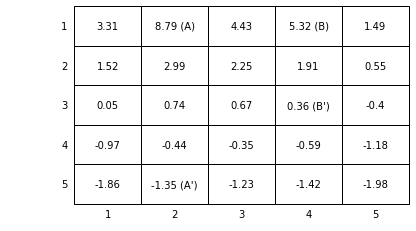

In [91]:
figure_3_2_linear_system()

### by evaluation-update iteration
We can make the table by going through an iteration of the Bellman equation until convergence.

In [92]:
def figure_3_2():
    value = np.zeros((WORLD_SIZE, WORLD_SIZE))
    while True:
        # keep iteration until convergence
        new_value = np.zeros_like(value)
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):  # for each state
                for action in ACTIONS:
                    (next_i, next_j), reward = step([i, j], action)
                    # bellman equation
                    new_value[i, j] += ACTION_PROB * (reward + DISCOUNT * value[next_i, next_j])
        if np.sum(np.abs(value - new_value)) < 1e-4:  # converged?
            draw_image(np.round(new_value, decimals=2))
            plt.show()
            plt.savefig('./images/figure_3_2.png')
            plt.close()
            break
        value = new_value
#

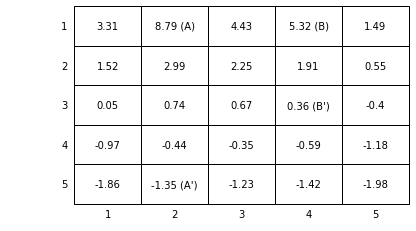

In [93]:
figure_3_2()

### Example 3.8: Solving the Gridworld - Solving the Bellman optimal equation

Intuitive, the Bellman optimality equation expresses the fact that the value of a state under an optimal policy must equal the expected return for the best action from that state:

\begin{align}
v_*(s) & = \max_{a\in\mathcal{A(s)}} q_{\pi_*}(s,a) \\
       & = \max_{a} \mathbb{E}_{\pi_*} [ G_t | S_t=s, A_t = a ] \\
       & = \max_{a} \mathbb{E}_{\pi_*} [ R_{t+1} + \gamma G_{t+1} | S_t=s, A_t = a ] \\
       & = \max_{a} \mathbb{E}  [ R_{t+1} + \gamma v_*(S_{t+1}) | S_t=s, A_t = a ] \quad\quad (3.19) \\
       & = \max_{a} \sum_{s', r} p(s', r|s, a) [r + \gamma v_*(s')] \quad\quad\quad\quad (3.19) \\
       & = \max_{a} \bigg\{ \frac{1}{N} \sum_i [r_i + \gamma v_*(s') | a, s] \bigg\} \quad\mbox{Monte Carlo Estimation from $N$ samples.}
\end{align}


In [102]:
def figure_3_5():
    value = np.zeros((WORLD_SIZE, WORLD_SIZE))
    while True:
        # keep iteration until convergence
        new_value = np.zeros_like(value)
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                values = []
                for action in ACTIONS:  # get samples (N=1, this)
                    (next_i, next_j), reward = step([i, j], action)  # for (s, a), obtain a sample of (s', r)
                    # value iteration
                    values.append(reward + DISCOUNT * value[next_i, next_j])
                new_value[i, j] = np.max(values)   # choose max !
        if np.sum(np.abs(new_value - value)) < 1e-4:
            value = new_value
            break;
        value = new_value
    return value
#

In [95]:
value = figure_3_5()

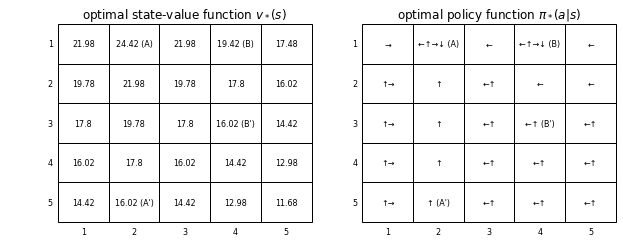

In [101]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
draw_image(np.round(value, decimals=2), axes[0])
draw_policy(value, axes[1])
axes[0].set(title='optimal state-value function $v_*(s)$')
axes[1].set(title='optimal policy function $\pi_*(a|s)$')
plt.show()

End.

In [112]:
(np.array([1, 0]) == np.array([1,0])).all()

True

In [ ]:
import numpy as np
from matplotlib.table import Table

class EnvGridWorldChap3:

    def __init__():
        self.WORLD_SIZE = 5
        self.A_POS = np.array([0, 1]       # position A
        self.A_PRIME_POS = np.array([4, 1] # A'
        self.B_POS = np.array([0, 3]       # B
        self.B_PRIME_POS = np.array([2, 3] # B'
        DISCOUNT = 0.9

        # left, up, right, down
        v
        self.ACTIONS = [np.array([0, -1]),  # left
                   np.array([-1, 0]),  # up
                   np.array([0, 1]),   # right
                   np.array([1, 0])]   # down
        self.ACTIONS_FIGS=[ '←', '↑', '→', '↓']

        
    def step(state, action):
        if state == A_POS:
            return A_PRIME_POS, 10
        if state == B_POS:
            return B_PRIME_POS, 5

        next_state = (np.array(state) + action).tolist()
        x, y = next_state
        if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
            reward = -1.0
            next_state = state
        else:
            reward = 0
        return next_state, reward
